# Subreddit Problem Finder

## Setup

Load libraries and utility Chatgpt function..

In [26]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from gensim import corpora, models
import json 
import openai
from textblob import TextBlob
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
import os
import networkx as nx
from collections import defaultdict
from itertools import combinations
import re
from dotenv import load_dotenv
from scraper import subreddit_name


In [27]:
import networkx as nx
from collections import defaultdict
from itertools import combinations
import re

In [28]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('vader_lexicon') 

In [29]:
# Load environment variables from .env.local
load_dotenv(dotenv_path='.env.local')
API_KEY = os.getenv('API_KEY')
openai.api_key = API_KEY

In [30]:
initial_prompt = f"""I am looking for a list of specific problems that could be solved with a SaaS or technology solution, 
  interpret these results from the {subreddit_name} subreddit and give me a list of 20 solvable and common problems only present in the text. """
def ask_chatgpt(question):
    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo-16k",
      messages=[
        {
          "role": "user",
          "content": question
        }
      ],
      temperature=1,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )
    answer = response.choices[0].message.content
      
    # Generate a timestamp in the format YYYYMMDD_HHMMSS
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Construct a filename using the timestamp
    filename = f'chatgpt_{timestamp}.txt'
    
    # Save the question and response to the file
    with open(filename, 'w') as f:
        f.write("Question:\n")
        f.write(question + "\n\n")
        f.write("Response:\n")
        f.write(answer)
    
    return answer

Loading latest scraped file

In [31]:
# Load the JSON file
with open('subreddit_data_excel_20230926_081308.json', 'r') as f:
    data = json.load(f)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data)

df['text'] = df['title'] + " " + df["content"]

df.head()


,title,content,score,num_comments,created_utc,text
0,Here are 20 Excel tips & functions to increase...,"**I've used Microsoft Excel for 20 years, and...",1144,112,1.665432e+09,Here are 20 Excel tips & functions to increase...
1,My ChatGPT excel plugin went viral because of ...,Hey [r/excel](https://www.reddit.com/r/excel/)...,1095,69,1.681935e+09,My ChatGPT excel plugin went viral because of ...
2,I made a plugin that uses ChatGPT to answer qu...,Hey r/excel. ChatGPT can now be used right ins...,781,86,1.680723e+09,I made a plugin that uses ChatGPT to answer qu...
3,My favorite 10 Excel shortcuts that will save ...,\n\n**I've worked 15+ years in Finance and us...,686,79,1.664580e+09,My favorite 10 Excel shortcuts that will save ...
4,Free Course: Microsoft Excel for Business Anal...,UPDATED 4/6 with a new coupon code!\n\nHey eve...,563,116,1.679585e+09,Free Course: Microsoft Excel for Business Anal...


In [32]:
# 1. Data Cleaning
df.drop_duplicates(subset=['text'], inplace=True)  # Remove duplicate entries
df.dropna(subset=['text'], inplace=True)           # Drop rows with missing text

# Normalize text data
df['cleaned_text'] = df['text'].str.lower()
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
df['cleaned_text'] = df['cleaned_text'].str.replace('\n', ' ')

In [33]:
df['cleaned_text'].head()

0    here are  excel tips  functions to increase pr...
1    my chatgpt excel plugin went viral because of ...
2    i made a plugin that uses chatgpt to answer qu...
3    my favorite  excel shortcuts that will save yo...
4    free course microsoft excel for business analy...
Name: cleaned_text, dtype: object

## Data Preprocessing

In [34]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

df['tokens'] = df['cleaned_text'].apply(preprocess)

## Basic Exploration of Data

[('excel', 738), ('cell', 420), ('data', 377), ('column', 339), ('xb', 335), ('formula', 332), ('im', 261), ('use', 250), ('would', 229), ('like', 224)]


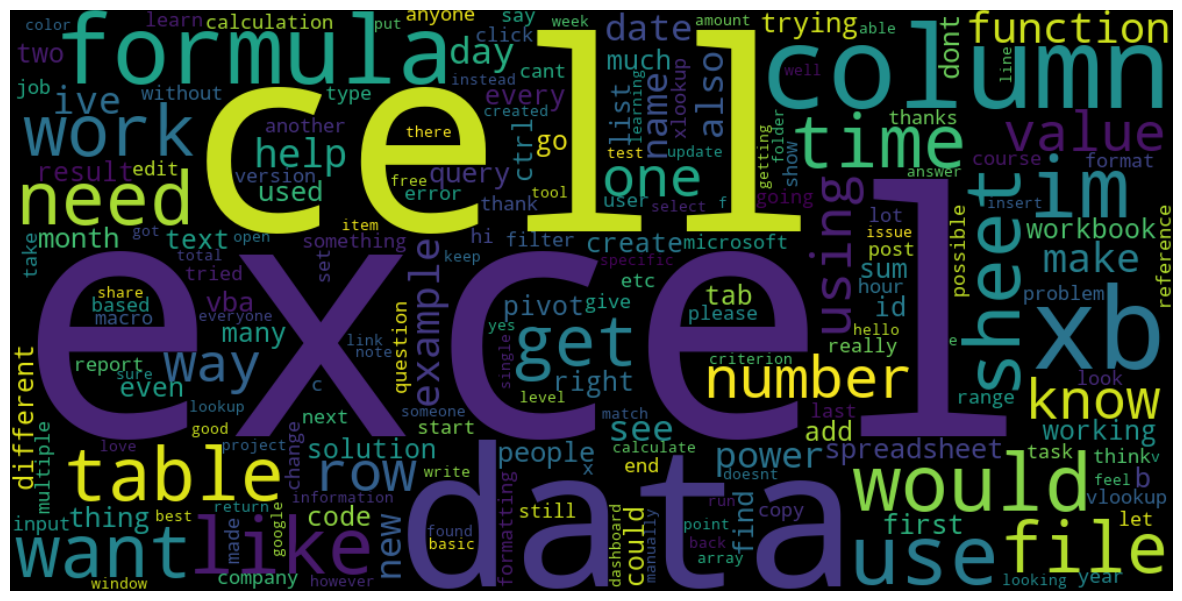

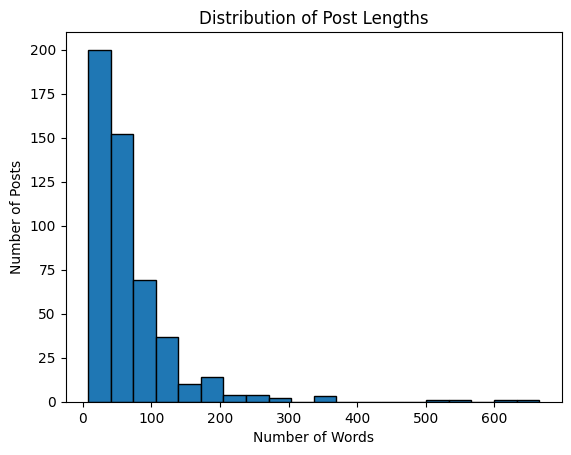

In [35]:
all_words = [word for token in df['tokens'] for word in token]
word_freq = Counter(all_words)
print(word_freq.most_common(10))  # Most common words

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Histogram example: Displaying distribution of post lengths
post_lengths = df['tokens'].apply(len)
plt.hist(post_lengths, bins=20, edgecolor='black')
plt.title('Distribution of Post Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Posts')
plt.show()

Removing high word count documents

In [36]:
df = df[post_lengths <= 400]

## Sentiment Analysis of Documents

In [37]:
sid = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['cleaned_text'].apply(vader_sentiment)
df['vader_polarity'] = df['cleaned_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [38]:
most_negative_texts = df.sort_values(by='vader_polarity', ascending=True).head(30)

sentiment_analysis_prompt = initial_prompt + "Theses are posts with high negative sentiment \n"
for index, row in most_negative_texts.iterrows():
    sentiment_analysis_prompt +=  f"\n Post {index}: "+ row['cleaned_text'] + "\n"


In [39]:
print(sentiment_analysis_prompt)

I am looking for a list of specific problems that could be solved with a SaaS or technology solution, 
  interpret these results from the Snowflake subreddit and give me a list of 20 solvable and common problems only present in the text. Theses are posts with high negative sentiment 

 Post 218: error excel ran out of resources while attempting to calculate hello everybody  im encountering a strange issue regarding a user in my team im the it guy for the whole floor and someone is having an issue with an excel file present on a file server the file is just any other finance related file a small one actually  kb with basic formulas present in cells like sum con etc but in a sheet with just some cells in a table she cant even sumab without getting the error in the screenshot but the formula still return the correct result every formula attempt gives the error but still returns the correct vallue     ive managed to get to page  of google to find some troubleshoot and by now ive tried   re

### Summation of Problems

In [40]:
ask_chatgpt_result = ask_chatgpt(sentiment_analysis_prompt)
print(ask_chatgpt_result)

1. Error with Excel running out of resources while attempting to calculate
2. Need to learn macros and VBA, but undo functionality is disabled
3. Feeling like an imposter in a reporting position, struggling with formulas and errors
4. Getting annoyed by starting data on cell A
5. Difficulty in using XLOOKUP to compare lists
6. Need for a reliable PDF to Excel converter
7. Issues with using VLOOKUP in merged cells
8. Trouble with VLOOKUP and INDEXMATCH functions not working properly
9. Need help with generating VBA for color format between worksheets
10. CTRL+Shift+Down not working with protected sheets
11. Concerns about using Excel on a MacBook and its performance
12. Questioning the necessity of the SUMIF formula and its alternatives
13. Why students do not take Excel certifications despite their importance
14. Issue with ALT+N shortcut conflicting with the find/replace dialogue
15. Difficulty in showing specific values based on conditions in Excel
16. Boss's dislike for macros and s

## Latent Dirichlet Allocation (LDA) of All documents

In [41]:
# Topic Modeling using LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=5)
print(lda.print_topics())  # Display topics

[(0, '0.018*"excel" + 0.011*"cell" + 0.009*"sheet" + 0.008*"use" + 0.007*"im" + 0.007*"formula" + 0.006*"day" + 0.006*"would" + 0.005*"column" + 0.005*"need"'), (1, '0.025*"excel" + 0.014*"cell" + 0.011*"formula" + 0.010*"like" + 0.009*"would" + 0.007*"data" + 0.007*"use" + 0.007*"file" + 0.007*"column" + 0.006*"need"'), (2, '0.020*"excel" + 0.011*"cell" + 0.010*"data" + 0.009*"time" + 0.008*"xb" + 0.008*"sheet" + 0.007*"use" + 0.007*"im" + 0.007*"get" + 0.007*"work"'), (3, '0.023*"excel" + 0.012*"data" + 0.009*"cell" + 0.008*"column" + 0.008*"formula" + 0.008*"im" + 0.007*"know" + 0.007*"one" + 0.007*"file" + 0.006*"power"'), (4, '0.021*"column" + 0.012*"formula" + 0.010*"data" + 0.010*"xb" + 0.009*"row" + 0.008*"excel" + 0.008*"cell" + 0.008*"want" + 0.007*"im" + 0.007*"table"')]


In [42]:
# Get the topic distribution for each document
document_topics = [lda[doc] for doc in corpus]

# Get the dominant topic for each document
df['dominant_topic'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][0] for doc in document_topics]

# Get the strength (weight) of the dominant topic for each document
df['topic_strength'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][1] for doc in document_topics]

# Extract text of topics
topic_raw_data = list(lda.show_topics())
topics = [re.findall(r'"\w+"', topic_str) for _, topic_str in topic_raw_data]
# Removing quotation marks around words
cleaned_topics = [[word[1:-1] for word in topic] for topic in topics]

# 2. Sort & Review
num_docs_to_review = 2  # or however many you want to review for each topic

lda_prompt = initial_prompt + "Theses are topics and document examples from Latent Dirichlet Allocation:"
for topic_num in range(lda.num_topics):
    topic = topic_raw_data[topic_num]
    # print(f"Top documents for Topic {topic_num}: {topic}")
    lda_prompt += f"LDA Topic {topic_num}: {topic}"
    
    top_docs_for_topic = df[df['dominant_topic'] == topic_num].sort_values('topic_strength', ascending=False).head(num_docs_to_review)
    for index, row in top_docs_for_topic.iterrows():
        lda_prompt  += f"\n Document : {index}. '{row['text']}'" 
    
# print(lda_prompt)

In [43]:
lda_ask_chatgpt_result = ask_chatgpt(lda_prompt)
print(lda_ask_chatgpt_result)

Based on the given text, here is a list of 20 solvable and common problems that can be addressed with a SaaS or technology solution:

1. Learning VBA coding without any prior experience or knowledge in coding
2. Maintaining depreciation and amortization schedules in QuickBooks Online
3. Miscounting using the COUNTIFS function with EOMONTH in Excel
4. Providing examples in Excel to quickly solve questions
5. Generating Sudoku puzzles in Excel
6. Feeling like an impostor in an Excel-based reporting position
7. Defining what it means to be an Excel guru
8. Using Excel without functional use of hands
9. Conditional formatting a calendar to identify conflicts in Excel
10. Creating an editable calendar view with deliverables and staff names in Excel
11. Building a visual aid to identify conflicts between out of office dates and assigned staff in Excel
12. Accessing Excel functions and formulas through voice commands for individuals with limited hand functionality
13. Using the COUNTIFS funct

## Latent Dirichlet Allocation(LDA) of all negative douments

In [44]:
df_negative = df[df["vader_sentiment"] == "negative"].copy(deep=True)

# Topic Modeling using LDA
dictionary = corpora.Dictionary(df_negative['tokens'])
corpus = [dictionary.doc2bow(text) for text in df_negative['tokens']]
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=5)


# Get the topic distribution for each document
document_topics = [lda[doc] for doc in corpus]

# Get the dominant topic for each document
df_negative['dominant_topic'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][0] for doc in document_topics]

# Get the strength (weight) of the dominant topic for each document
df_negative['topic_strength'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][1] for doc in document_topics]

# Extract text of topics
topic_raw_data = list(lda.show_topics())
topics = [re.findall(r'"\w+"', topic_str) for _, topic_str in topic_raw_data]
# Removing quotation marks around words
cleaned_topics = [[word[1:-1] for word in topic] for topic in topics]

# 2. Sort & Review
num_docs_to_review = 2  # or however many you want to review for each topic

negative_lda_prompt = initial_prompt + "Theses are topics and document examples from Latent Dirichlet Allocation:"
for topic_num in range(lda.num_topics):
    topic = topic_raw_data[topic_num]
    negative_lda_prompt += f"LDA Topic {topic_num}: {topic}"
    
    top_docs_for_topic = df_negative[df_negative['dominant_topic'] == topic_num].sort_values('topic_strength', ascending=False).head(num_docs_to_review)
    for index, row in top_docs_for_topic.iterrows():
        negative_lda_prompt  += f"\n Document Example: {index}. '{row['text']}'" 
    
# print(negative_lda_prompt)

In [45]:
negative_lda_ask_chatgpt_result = ask_chatgpt(lda_prompt)
print(negative_lda_ask_chatgpt_result)

Based on the provided LDA topics and the text excerpts, here is a list of 20 solvable and common problems that could be solved with a SaaS or technology solution:

1. Automating depreciation and amortization schedules in QuickBooks Online
2. Learning VBA coding without any prior coding knowledge
3. Generating sequential outputs in Excel
4. Managing and checking for conflicts in project deadlines
5. Creating an editable calendar view for project management
6. Highlighting conflicts between assigned staff and out-of-office dates
7. Creating complex formulas and VBA code for Excel
8. Building a Sudoku generator in Excel
9. Using Excel without functional use of hands
10. Formatting and organizing data in Excel for analysis and reporting
11. Creating dynamic ranges using OFFSET and SUM or AVERAGE functions
12. Efficiently using Excel shortcuts and tricks for improved productivity
13. Applying conditional formatting to highlight specific data points
14. Building user-friendly and interactive

In [46]:
# Define the number of topics you want
n_topics = 10

# Transform data using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['text'])

# Apply NMF
nmf = NMF(n_components=n_topics, init='nndsvd', solver='cd', beta_loss='frobenius', random_state=1, l1_ratio=.5).fit(tfidf)

# Print the topics discovered by NMF
feature_names = tfidf_vectorizer.get_feature_names_out()
top_10_per_topic_list = []
for topic_idx, topic in enumerate(nmf.components_):
    top_10_per_topic_list.append(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    
# First, transform your original matrix using the trained NMF model
W = nmf.transform(tfidf)

# Assign the topic with the highest coefficient as the dominant topic for each text
df['dominant_topic'] = W.argmax(axis=1)

# Now, extract and review texts for each topic
documents_per_topic = 5

nmf_prompt = initial_prompt + "Theses are topics and document examples from Non-negative Matrix Factorization \n"
for topic_num in range(nmf.n_components_):  # Loop through all topics
    nmf_prompt += f"Topic #{topic_num + 1} top words: {top_10_per_topic_list[topic_num]}\n"
    
    sample_texts_for_topic = df[df['dominant_topic'] == topic_num]['text'].sample(documents_per_topic)
    
    for idx, text in sample_texts_for_topic.items():
        nmf_prompt += f"Document {idx}: {text}"
    nmf_prompt += '\n'

/Users/matthewcarter/.local/share/virtualenvs/reddit-scraper-_tJTTXAU/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [47]:
# print(nmf_prompt)

In [48]:
nmf_ask_chatgpt_result = ask_chatgpt(nmf_prompt)
print(nmf_ask_chatgpt_result)

Based on the provided text, here is a list of 20 solvable and common problems that could be solved with a SaaS or technology solution:

1. Creating visually appealing dashboards for portfolio projects.
2. Improving the design and visual appeal of Excel templates.
3. Joining and merging data from multiple reports.
4. Creating an editable calendar view for managing staff deadlines.
5. Conditional formatting a calendar to highlight conflicts.
6. Recording last date modified for one cell in another cell without VBA.
7. Creating weekly PowerPoint presentations from Excel product exports.
8. Learning Excel formulas, pivot tables, and keyboard functions.
9. Adding digital signatures to Excel files for document traceability.
10. Monetizing spreadsheet building skills.
11. Setting up recurring, monthly events in Excel.
12. Reviewing for an Excel competency test.
13. Generating responses to questions using AI bots like ChatGPT.
14. Converting incorrectly formatted numbers for proper calculations